# Web Scraping Weather Data

In [328]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import datetime
import time


#Selects the date range for the web scraping, currently set to 2022 full year
start_date = datetime.datetime(2021, 1, 1)
today_date = datetime.datetime(2021, 12, 31)
# today_date = datetime.datetime.today()


# Generate a list of dates between the start and end dates
date_range = [start_date + datetime.timedelta(days=x) for x in range((today_date - start_date).days + 1)]

# Format the dates as strings delimited by hyphens for our link
date_range_hyphen = [date.strftime('%Y-%m-%d') for date in date_range]

for date in date_range_hyphen:
    # Specify the URL and use requests to get the HTML content
    url = f'https://www.wunderground.com/dashboard/pws/KNYJACKS2/table/{today_date}/{date}/daily'
    response = requests.get(url)
    html_content = response.content

    # Parse the HTML content using Beautiful Soup
    soup = BeautifulSoup(html_content, 'html.parser')

    # Find the last table on the page and extract the data into a list of lists
    print(date)
    table = soup.find_all('table')[-1]
    rows = table.find_all('tr')
    data = []
    for row in rows:
        cols = row.find_all('td')
        cols = [col.text.strip() for col in cols]
        data.append(cols)
    data[0] = ['Time', 'Temperature', 'Dew_Point', 'Humidity', 'Wind', 'Speed', 'Gust', 'Pressure', 'Precip_Rate', 'Precip_Accum', 'UV', 'Solar']

    # Convert the list of lists into a pandas dataframe
    # Print statements just show where data may have to be imputed, and also slow the program down so it doesn't outpace my internet
    try:
        df = pd.DataFrame(data[2:], columns=data[0])
    except:
        print(date)
    df['Time'] = pd.to_datetime(df['Time'], format='%I:%M %p')
    df['hour'] = df['Time'].dt.hour
    try:
        df.drop('Wind', axis = 1, inplace = True)
    except:
        print(date, 'wind problem')

    #Tries to change datatypes to numerical data, print statements show where data will need to be imputed later
    for col in df:
        if col == 'UV':
            df[col] = pd.to_numeric(df[col])
        elif df[col].dtypes == 'object':
            df[col] = df[col].map(lambda x: x.split()[0])
            try:
                df[col] = pd.to_numeric(df[col])
            except:
                print(date, col)
    df_hourly = df.groupby(df.hour).mean()
    df_hourly['date'] = date
    df_hourly.reset_index(inplace=True)

    #Inits our weather dataframe the first pass through, and concats grouped data to it each time after, reusing as much as possible to use less ram
    if date == str(start_date.date()):
        dfw = df_hourly
    else:
        dfw = pd.concat([dfw,df_hourly], ignore_index=True)

2021-01-01
2021-01-02
2021-01-03
2021-01-04
2021-01-05
2021-01-06
2021-01-07
2021-01-08
2021-01-09
2021-01-10
2021-01-11
2021-01-12
2021-01-13
2021-01-14
2021-01-15
2021-01-16
2021-01-17
2021-01-18
2021-01-19
2021-01-20
2021-01-21
2021-01-22
2021-01-23
2021-01-24
2021-01-24 Gust
2021-01-25
2021-01-26
2021-01-27
2021-01-27 Gust
2021-01-28
2021-01-29
2021-01-29 Temperature
2021-01-29 Dew_Point
2021-01-29 Humidity
2021-01-29 Speed
2021-01-29 Gust
2021-01-29 Solar
2021-01-30
2021-01-31
2021-02-01
2021-02-01 Speed
2021-02-01 Gust
2021-02-02
2021-02-03
2021-02-04
2021-02-05
2021-02-06
2021-02-07
2021-02-08
2021-02-09
2021-02-10
2021-02-11
2021-02-12
2021-02-13
2021-02-14
2021-02-15
2021-02-15 Gust
2021-02-16
2021-02-17
2021-02-18
2021-02-18 Gust
2021-02-19
2021-02-20
2021-02-21
2021-02-22
2021-02-23
2021-02-24
2021-02-25
2021-02-26
2021-02-27
2021-02-28
2021-03-01
2021-03-02
2021-03-03
2021-03-04
2021-03-04 Gust
2021-03-05
2021-03-05 Gust
2021-03-06
2021-03-06 Temperature
2021-03-06 Dew_Poin

Cleaning the Data

In [ ]:
dfw['Gust'].fillna(0, inplace=True)


In [ ]:
#Changes datatype for merge
dfw['date'] = pd.to_datetime(dfw['date'])

In [ ]:
dfw.date.value_counts()

2022-01-01    24
2022-09-07    24
2022-09-05    24
2022-09-04    24
2022-09-03    24
              ..
2022-03-13    23
2022-11-27    21
2022-06-01    17
2022-09-21    12
2022-06-02    12
Name: date, Length: 363, dtype: int64

## Getting Holidays via API

In [322]:
import requests
url = 'https://holidayapi.com/v1/holidays'
params = {
    'country':'US-NY',
    'year':'2022',
    'pretty': True,
    'key' : '734138b2-a9b0-4476-8dca-9edaf8116472'
}

params2 = {
    'country':'US-NY',
    'year':'2021',
    'pretty': True,
    'key' : '734138b2-a9b0-4476-8dca-9edaf8116472'
}
response = requests.get(url, params=params)
response2= requests.get(url, params=params2)
hols = response.json()
hols2= response2.json()
hols = hols['holidays']
# hols2= hols2['holidays']
print(hols2)

dfh = pd.json_normalize(hols)
dfh2 = pd.json_normalize(hols2)
dfh = pd.concat(dfh2, dfh,ignore_index=True)

display(dfh)

{'status': 402, 'requests': {'used': 17, 'available': 9983, 'resets': '2023-06-01 00:00:00'}, 'error': "Free accounts are limited to last year's historical data only. Upgrade to premium for access to all holiday data. For more information, please visit https://holidayapi.com/docs"}


C:\Users\msciz\AppData\Local\Temp\ipykernel_23012\503415615.py:26: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  dfh = pd.concat(dfh2, dfh,ignore_index=True)


TypeError: first argument must be an iterable of pandas objects, you passed an object of type "DataFrame"

Cleaning the data

In [ ]:
dfh['weekday.date.numeric'] = dfh['weekday.date.numeric'].map(lambda x: int(x)-1)
dfh['weekday.observed.numeric'] = dfh['weekday.observed.numeric'].map(lambda x: int(x)-1)



## Reading in Taxi Data

In [3]:
#List of months to iterate through the files
years = ['2021','2022']
months = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11','12']

In [5]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import datetime
import time
#Creates loop to read in and concat 
for year in years:
    i=1

    for month in months:                   
        df = pd.read_parquet(f'yellow_tripdata_{year}-{month}.parquet', engine='pyarrow')

        df['date'] = pd.to_datetime(df['tpep_pickup_datetime'].dt.date)
        df['hour'] = df['tpep_pickup_datetime'].dt.hour

        df['Trip_Length'] = df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']
        if month != months[-1]:
            start = pd.to_datetime(f'{year}-{month}-01')
            end = pd.to_datetime(f'{year}-{months[i]}-01')
            df = df[(df['date'] >= start) & (df['date'] < end)]
            i +=1
        else:
            df = df[(df['date'] >= pd.to_datetime(f'{year}-{month}-01')) & (df['date'] < pd.to_datetime(f'2023-01-01'))]
        df = df.groupby(['date', 'hour']).agg({'passenger_count':['sum', 'count'], 'trip_distance':['sum', 'mean'], 'total_amount':'sum', 'Trip_Length':['sum', 'mean']})
        df.reset_index(inplace=True)
        if month == '01' and year == years[0]:
            dfg = df
        else:
            dfg = pd.concat([dfg,df], ignore_index = True)

In [326]:
# Resets column names for clarity
dfg.columns = ['date', 'hour', 'Total Passengers', 'Amount of Trips', 'Total Distance', 'Average Distance','Total Fares', 'Total Time', 'Averge Time']
dfg['day_of_week'] = dfg['date'].dt.dayofweek


In [330]:
dfw.head()

,hour,Temperature,Dew_Point,Humidity,Speed,Gust,Pressure,Precip_Rate,Precip_Accum,UV,Solar,date
0,0,37.000000,23.716667,58.083333,0.091667,1.650000,30.422500,0.0,0.0,0.0,0.0,2021-01-01
1,1,36.566667,23.691667,59.250000,0.225000,2.483333,30.443333,0.0,0.0,0.0,0.0,2021-01-01
2,2,36.058333,23.458333,60.000000,0.341667,3.600000,30.466667,0.0,0.0,0.0,0.0,2021-01-01
3,3,35.591667,23.250000,60.416667,0.075000,0.583333,30.475833,0.0,0.0,0.0,0.0,2021-01-01
4,4,35.166667,23.291667,61.416667,0.066667,0.833333,30.480833,0.0,0.0,0.0,0.0,2021-01-01


### Merging the data

In [56]:
#Inner Join the two data sets
dfgw = dfg.set_index(['date', 'hour']).join(dfw.set_index(['date', 'hour']), how='inner')

In [58]:
dfh.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147 entries, 0 to 146
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   name                      147 non-null    object
 1   date                      147 non-null    object
 2   observed                  147 non-null    object
 3   public                    147 non-null    bool  
 4   country                   147 non-null    object
 5   uuid                      147 non-null    object
 6   weekday.date.name         147 non-null    object
 7   weekday.date.numeric      147 non-null    int64 
 8   weekday.observed.name     147 non-null    object
 9   weekday.observed.numeric  147 non-null    int64 
dtypes: bool(1), int64(2), object(7)
memory usage: 10.6+ KB


In [62]:
dfgw.reset_index(inplace=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8676 entries, 0 to 8675
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype          
---  ------            --------------  -----          
 0   date              8676 non-null   datetime64[ns] 
 1   hour              8676 non-null   int64          
 2   Total Passengers  8676 non-null   float64        
 3   Amount of Trips   8676 non-null   int64          
 4   Total Distance    8676 non-null   float64        
 5   Average Distance  8676 non-null   float64        
 6   Total Fares       8676 non-null   float64        
 7   Total Time        8676 non-null   timedelta64[ns]
 8   Averge Time       8676 non-null   timedelta64[ns]
 9   day_of_week       8676 non-null   int64          
 10  Temperature       8652 non-null   float64        
 11  Dew_Point         8652 non-null   float64        
 12  Humidity          8652 non-null   float64        
 13  Speed             8652 non-null   float64        
 14  Gust    

In [59]:
dfh['observed'] = pd.to_datetime(dfh['observed'])
dfh['date'] = pd.to_datetime(dfh['date'])


In [105]:
#Left join with the holiday data
dfgwh = dfgw.set_index('date').join(dfh.set_index('date'), how='left')

In [81]:
dfgwh.public.value_counts()

False    3236
True      288
Name: public, dtype: int64

Send to CSV for EDA

In [6]:
dfg.to_csv('Cleaned_Taxi_21-22.csv')


In [67]:
dfw.to_csv('Cleaned_Weather_2021.csv')
dfh.to_csv('Cleaned_Holidays.csv')
dfgwh.to_csv('Cleaned_Merge.csv')

In [ ]:
# import pandas as pd
# dfgwh = pd.read_csv('Cleaned_Merge.csv')

## ML in progress

In [93]:
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error
from sklearn import linear_model
import statistics
import matplotlib.pyplot as plt
import math
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tsa.arima.model import ARIMA
import numpy as np

Null Checking

In [35]:
dfgwh['name'].value_counts()

Seventh Day of Kwanzaa              24
Epiphany                            24
Citizenship Day                     24
National CleanUp Day                24
Air Force Birthday                  24
                                    ..
National Day of Prayer              24
Kentucky Oaks                       24
Military Spouse Appreciation Day    24
Start of Daylight Saving Time       23
First Sunday of Advent              21
Name: name, Length: 146, dtype: int64

In [41]:
dfh.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147 entries, 0 to 146
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   name                      147 non-null    object        
 1   date                      147 non-null    datetime64[ns]
 2   observed                  147 non-null    datetime64[ns]
 3   public                    147 non-null    bool          
 4   country                   147 non-null    object        
 5   uuid                      147 non-null    object        
 6   weekday.date.name         147 non-null    object        
 7   weekday.date.numeric      147 non-null    int64         
 8   weekday.observed.name     147 non-null    object        
 9   weekday.observed.numeric  147 non-null    int64         
dtypes: bool(1), datetime64[ns](2), int64(2), object(5)
memory usage: 10.6+ KB


In [100]:
nulls = dfgwh[dfgwh.isna().any(axis=1)]
display(nulls)

,hour,Total Passengers,Amount of Trips,Total Distance,Average Distance,Total Fares,Total Time,Averge Time,day_of_week,Temperature,...,Solar,name,observed,public,country,uuid,weekday.date.name,weekday.date.numeric,weekday.observed.name,weekday.observed.numeric
date,,,,,,,,,,,,,,,,,,,,,
2022-01-02,0,2246.0,1441,8088.28,5.453999,37487.75,18 days 11:45:37,0 days 00:17:57.233310856,6,50.541667,...,0.0,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-02,1,1567.0,989,5050.80,4.971260,24711.37,11 days 21:27:25,0 days 00:16:51.461614173,6,50.008333,...,0.0,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-02,2,1026.0,682,3130.24,4.452688,15187.80,9 days 18:24:52,0 days 00:20:00.415362731,6,50.283333,...,0.0,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-02,3,764.0,490,2167.32,4.317371,10912.84,7 days 23:48:17,0 days 00:22:55.492031872,6,51.858333,...,0.0,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-02,4,506.0,336,1775.48,4.973333,8822.61,3 days 03:13:07,0 days 00:12:38.507002801,6,53.016667,...,0.0,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-18,19,7960.0,5417,20278.99,3.598117,123117.29,71 days 03:19:16,0 days 00:18:10.552874378,6,37.508333,...,0.0,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-18,20,7510.0,4995,19055.02,3.679286,113987.82,56 days 06:25:59,0 days 00:15:38.706120872,6,36.966667,...,0.0,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-18,21,6970.0,4626,18085.73,3.795536,106639.76,51 days 08:10:50,0 days 00:15:30.923399790,6,36.166667,...,0.0,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Cleaning for ML

In [108]:
dfgwh['public'].value_counts()

0.0    5824
1.0    3236
2.0     288
Name: public, dtype: int64

In [102]:
#Declare functions for apply statements
def publicclean(x):        
    if x == False:
        return 1
    elif x == True:
        return 2


In [107]:
#Cleaning Holiday Nulls
dfgwh['public'] = dfgwh['public'].apply(publicclean)
dfgwh['public'].fillna(0, inplace=True)
dfgwh.drop(['name', 'country', 'uuid', 'weekday.date.name', 'weekday.date.numeric'], axis = 1, inplace=True)
# dfgwh.rename(columns = {'observed': 'date'})
dfgwh.drop(['weekday.observed.name', 'weekday.observed.numeric', 'observed'], axis=1, inplace=True)


In [109]:
dfgwh.dropna(axis=0, inplace=True)

XGboost attempt

In [89]:
import xgboost as xgb

In [113]:
dfgwh.head()

,hour,Total Passengers,Amount of Trips,Total Distance,Average Distance,Total Fares,day_of_week,Temperature,Dew_Point,Humidity,Speed,Gust,Pressure,Precip_Rate,Precip_Accum,UV,Solar,public
date,,,,,,,,,,,,,,,,,,
2022-01-01,0,6716.0,4139,14253.79,3.345175,85222.39,5,50.266667,47.350000,89.916667,0.0,0.0,29.919167,0.0,0.0,0.0,0.0,2.0
2022-01-01,0,6716.0,4139,14253.79,3.345175,85222.39,5,50.266667,47.350000,89.916667,0.0,0.0,29.919167,0.0,0.0,0.0,0.0,1.0
2022-01-01,1,7391.0,4650,16036.43,3.209212,97587.01,5,50.266667,47.366667,90.000000,0.0,0.0,29.911667,0.0,0.0,0.0,0.0,2.0
2022-01-01,1,7391.0,4650,16036.43,3.209212,97587.01,5,50.266667,47.366667,90.000000,0.0,0.0,29.911667,0.0,0.0,0.0,0.0,1.0
2022-01-01,2,5703.0,3630,12345.28,3.164645,75531.61,5,50.400000,47.525000,90.000000,0.0,0.0,29.910000,0.0,0.0,0.0,0.0,2.0


In [110]:
#Insert this below on X before committing!
dfgwh.drop(['Total Time', 'Averge Time'], axis='columns', inplace = True)

In [114]:
dfgwh.drop_duplicates(inplace=False)

,hour,Total Passengers,Amount of Trips,Total Distance,Average Distance,Total Fares,day_of_week,Temperature,Dew_Point,Humidity,Speed,Gust,Pressure,Precip_Rate,Precip_Accum,UV,Solar,public
date,,,,,,,,,,,,,,,,,,
2022-01-01,0,6716.0,4139,14253.79,3.345175,85222.39,5,50.266667,47.350000,89.916667,0.0,0.0,29.919167,0.000000,0.000000,0.0,0.0,2.0
2022-01-01,0,6716.0,4139,14253.79,3.345175,85222.39,5,50.266667,47.350000,89.916667,0.0,0.0,29.919167,0.000000,0.000000,0.0,0.0,1.0
2022-01-01,1,7391.0,4650,16036.43,3.209212,97587.01,5,50.266667,47.366667,90.000000,0.0,0.0,29.911667,0.000000,0.000000,0.0,0.0,2.0
2022-01-01,1,7391.0,4650,16036.43,3.209212,97587.01,5,50.266667,47.366667,90.000000,0.0,0.0,29.911667,0.000000,0.000000,0.0,0.0,1.0
2022-01-01,2,5703.0,3630,12345.28,3.164645,75531.61,5,50.400000,47.525000,90.000000,0.0,0.0,29.910000,0.000000,0.000000,0.0,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31,19,8237.0,5383,17976.17,3.137202,144147.13,5,52.333333,49.925000,91.416667,0.0,0.0,29.836667,0.010833,0.050833,0.0,0.0,1.0
2022-12-31,20,8863.0,5654,20978.73,3.378217,164999.95,5,53.083333,50.758333,92.000000,0.0,0.0,29.804167,0.033333,0.082500,0.0,0.0,1.0
2022-12-31,21,8464.0,5345,182973.76,30.689997,164002.76,5,54.158333,51.808333,92.000000,0.0,0.0,29.792500,0.053333,0.135000,0.0,0.0,1.0


In [116]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error

In [148]:
X.columns

Index(['hour', 'Average Distance', 'day_of_week', 'Temperature', 'Dew_Point',
       'Humidity', 'Speed', 'Gust', 'Pressure', 'Precip_Rate', 'Precip_Accum',
       'UV', 'Solar', 'public'],
      dtype='object')

In [173]:
dfgwh.reset_index(inplace=True)
dfgwh.set_index('date', inplace=True)

In [174]:
dfgwh.head()

,hour,Total Passengers,Amount of Trips,Total Distance,Average Distance,Total Fares,day_of_week,Temperature,Dew_Point,Humidity,Speed,Gust,Pressure,Precip_Rate,Precip_Accum,UV,Solar,public
date,,,,,,,,,,,,,,,,,,
2022-01-01,0,6716.0,4139,14253.79,3.345175,85222.39,5,50.266667,47.350000,89.916667,0.0,0.0,29.919167,0.0,0.0,0.0,0.0,2.0
2022-01-01,0,6716.0,4139,14253.79,3.345175,85222.39,5,50.266667,47.350000,89.916667,0.0,0.0,29.919167,0.0,0.0,0.0,0.0,1.0
2022-01-01,1,7391.0,4650,16036.43,3.209212,97587.01,5,50.266667,47.366667,90.000000,0.0,0.0,29.911667,0.0,0.0,0.0,0.0,2.0
2022-01-01,1,7391.0,4650,16036.43,3.209212,97587.01,5,50.266667,47.366667,90.000000,0.0,0.0,29.911667,0.0,0.0,0.0,0.0,1.0
2022-01-01,2,5703.0,3630,12345.28,3.164645,75531.61,5,50.400000,47.525000,90.000000,0.0,0.0,29.910000,0.0,0.0,0.0,0.0,2.0


706.9264675436966 928.3295048757502


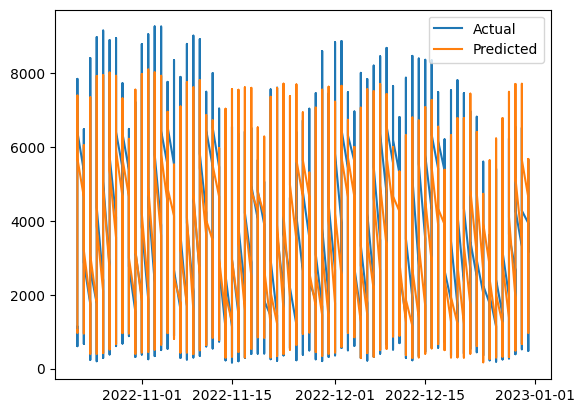

0.8590281571342235 0.951030181680923


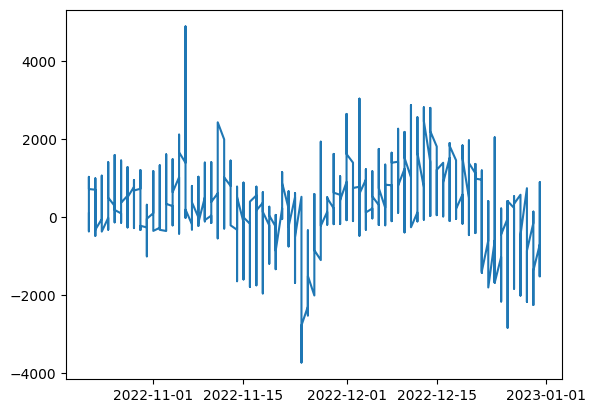

In [232]:


X = dfgwh.drop(['Amount of Trips','Average Distance', 'Total Fares', 'Total Passengers', 'Total Distance'], axis = 1)
y = dfgwh['Amount of Trips']

Xtrain, Xtest, ytrain, ytest = train_test_split(X,y, test_size=0.2, shuffle=False)

xmodel = xgb.XGBRegressor(learning_rate = 0.05, tree_method = 'hist', max_depth = 5, min_child_weight = 3 )

# hpgrid = {
#     'max_depth' : [3,5,7],
#     'learning_rate' : [0.1, 0.01, 0.001],
#     'n_estimators': [100,500,1000]
# }

# GridSearch = GridSearchCV(estimator = xmodel, param_grid = hpgrid, cv = 3, scoring = 'neg_mean_absolute_error')
# GridSearch.fit(Xtrain, ytrain)

# bestHP = GridSearch.best_params_
# print(bestHP, bestScore)


xmodel.fit(Xtrain, ytrain)

preds = xmodel.predict(Xtest)

mae = mean_absolute_error(ytest, preds)
rmse = np.sqrt(mean_squared_error(ytest, preds))

print(mae, rmse)

plt.plot(Xtest.index, ytest, label = 'Actual')
plt.plot(Xtest.index, preds, label = 'Predicted')
plt.legend()
plt.show()
print(xmodel.score(Xtest, ytest), xmodel.score(Xtrain, ytrain))

plt.plot(Xtest.index, ytest - preds)
plt.show()

### Hyper Param tuning

In [124]:
def getTotalAbsoluteError(Xt, yt, modelinput):
    predictedvalues = modelinput.predict(Xt)
    error = yt - predictedvalues
    return(sum(abs(error)))

#### Max Depth

[0.7957261799685439, 0.8445121903759445, 0.8324832622767947, 0.8378028223148404, 0.8351701049275619, 0.825092102575853, 0.8444993940364293, 0.8293051402338578, 0.8318091293114159]


C:\Users\msciz\AppData\Local\Temp\ipykernel_23012\3999570277.py:16: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "rs-" (-> color='r'). The keyword argument will take precedence.
  ax.plot(errIndex, err, 'rs-', color= 'orange', linewidth=1.5)
C:\Users\msciz\AppData\Local\Temp\ipykernel_23012\3999570277.py:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "rs-" (-> color='r'). The keyword argument will take precedence.
  ax.plot(errIndex, errTest, 'rs-', color='green', linewidth= 1.5)


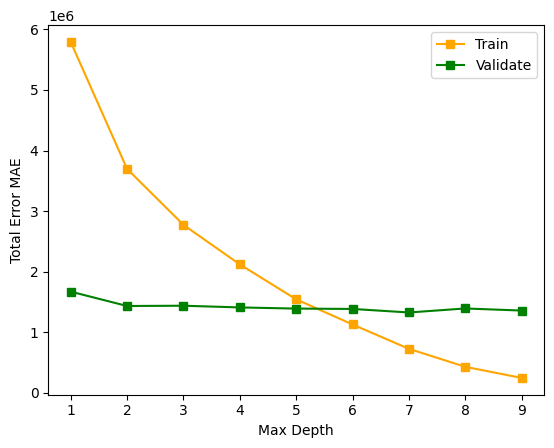

In [222]:
err = []
errIndex = []
errTest = []
scores = []
for depth in range(1,10):
    xmodel = xgb.XGBRegressor( max_depth = depth)
    xmodel.fit(Xtrain, ytrain)
    err.append(getTotalAbsoluteError(Xtrain, ytrain, xmodel))
    errTest.append(getTotalAbsoluteError(Xtest, ytest, xmodel))
    errIndex.append(depth)
    scores.append(xmodel.score(Xtest, ytest))

print(scores)

fig, ax = plt.subplots()
ax.plot(errIndex, err, 'rs-', color= 'orange', linewidth=1.5)
ax.plot(errIndex, errTest, 'rs-', color='green', linewidth= 1.5)
ax.set_xlabel('Max Depth')
ax.set_ylabel('Total Error MAE')
plt.legend(['Train', 'Validate'])

#### N Estimators

[-1.1233848013477488, -0.16511023071102016, 0.33700793093446857, 0.5806951674090415, 0.7072913138732513, 0.7718673758217832, 0.8068796162082391, 0.8227715867379628, 0.8318672562537228, 0.8368624939199307, 0.8384593950786218, 0.8398369874019558, 0.8410754749814466, 0.839725439798507, 0.8388833388163317, 0.8381492082735792, 0.8397883494382884, 0.8393999895187303, 0.8377513836131718, 0.8375258548389305, 0.8372653311243548, 0.8361456037198187, 0.8354605981441154, 0.8355949901551327, 0.8352178809695425, 0.8351647350361442, 0.8344719009421933, 0.8347375604180411, 0.8343202710593236, 0.8339813057040653, 0.8339169652096388, 0.8320851667165271, 0.8309647328709953, 0.8319178484561092, 0.8329994200022314, 0.8326577841721061, 0.8327368929568477, 0.8319446665181114, 0.830476654207208, 0.8302166824448209, 0.8300162989757487, 0.8287068672659869, 0.828610303116874, 0.8271824570494943, 0.8272650530433258, 0.827085360189341, 0.8266660656301376, 0.8266793744362742, 0.8269233489129315, 0.8269304390559213,

C:\Users\msciz\AppData\Local\Temp\ipykernel_23012\3187569543.py:14: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "rs-" (-> color='r'). The keyword argument will take precedence.
  ax.plot(errIndex, err, 'rs-', color= 'orange', linewidth=1.5)
C:\Users\msciz\AppData\Local\Temp\ipykernel_23012\3187569543.py:15: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "rs-" (-> color='r'). The keyword argument will take precedence.
  ax.plot(errIndex, errTest, 'rs-', color='green', linewidth= 1.5)


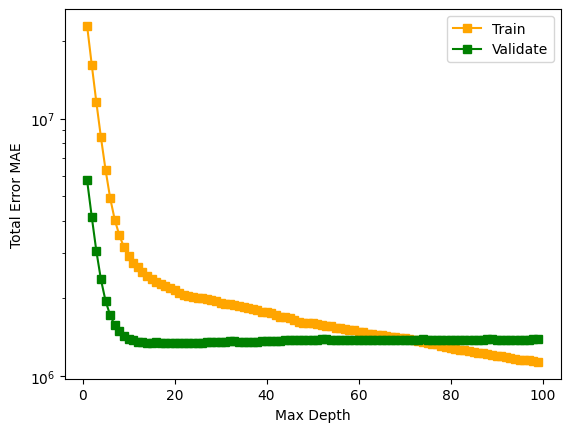

In [228]:
err = []
errIndex = []
errTest = []
scores = []
for depth in range(1,100):
    xmodel = xgb.XGBRegressor(n_estimators = depth)
    xmodel.fit(Xtrain, ytrain)
    err.append(getTotalAbsoluteError(Xtrain, ytrain, xmodel))
    errTest.append(getTotalAbsoluteError(Xtest, ytest, xmodel))
    errIndex.append(depth)
    scores.append(xmodel.score(Xtest, ytest))

fig, ax = plt.subplots()
ax.plot(errIndex, err, 'rs-', color= 'orange', linewidth=1.5)
ax.plot(errIndex, errTest, 'rs-', color='green', linewidth= 1.5)
ax.set_xlabel('Max Depth')
ax.set_ylabel('Total Error MAE')
ax.set_yscale('log')
plt.legend(['Train', 'Validate'])
print(scores)

#### Min Child Weight

[0.825092102575853, 0.8361507083098803, 0.8424573606352784, 0.8303203841164333, 0.8235182535220718, 0.8325309797124365, 0.8397152705643529, 0.831703379172552, 0.8358699801166412]


C:\Users\msciz\AppData\Local\Temp\ipykernel_23012\2889037552.py:14: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "rs-" (-> color='r'). The keyword argument will take precedence.
  ax.plot(errIndex, err, 'rs-', color= 'orange', linewidth=1.5)
C:\Users\msciz\AppData\Local\Temp\ipykernel_23012\2889037552.py:15: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "rs-" (-> color='r'). The keyword argument will take precedence.
  ax.plot(errIndex, errTest, 'rs-', color='green', linewidth= 1.5)


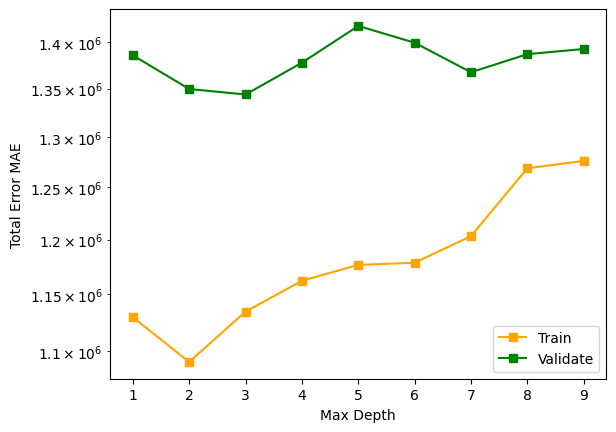

In [229]:
err = []
errIndex = []
errTest = []
scores = []
for depth in range(1,10):
    xmodel = xgb.XGBRegressor( min_child_weight = depth)
    xmodel.fit(Xtrain, ytrain)
    err.append(getTotalAbsoluteError(Xtrain, ytrain, xmodel))
    errTest.append(getTotalAbsoluteError(Xtest, ytest, xmodel))
    errIndex.append(depth)
    scores.append(xmodel.score(Xtest, ytest))

fig, ax = plt.subplots()
ax.plot(errIndex, err, 'rs-', color= 'orange', linewidth=1.5)
ax.plot(errIndex, errTest, 'rs-', color='green', linewidth= 1.5)
ax.set_xlabel('Min Child Weight')
ax.set_ylabel('Total Error MAE')
ax.set_yscale('log')
plt.legend(['Train', 'Validate'])
print(scores)

#### Sub Samples

[-3.1022565196195853, 0.39217831795017966, 0.5639871999232825, 0.7057038793109631, 0.7433558989918817, 0.7647908049022623, 0.7444662273677698, 0.7812244207211642, 0.7841519177394197, 0.7820084842535512, 0.7636218111859796, 0.7937488915719174, 0.772947063137247, 0.7919346337199664, 0.8131785971534035, 0.802679485335744, 0.8014655234845905, 0.820828516956114, 0.8266584924991978, 0.831516757190663, 0.8215335103382221, 0.8299646203768242, 0.7941181625140245, 0.824787253577874, 0.8146170237401533, 0.8091552822427488, 0.8246047261556406, 0.8225810674385429, 0.8260250355494608, 0.8285027431323113, 0.8210526451294062, 0.8194431776651281, 0.8303064146688723, 0.8293070716191493, 0.8328747687471468, 0.8297375415868691, 0.8441887959367749, 0.8261498880622579, 0.8123945536686827, 0.8343486924077943, 0.8390650346692389, 0.8104114415636299, 0.8256370304579524, 0.8265371785194252, 0.8265139285946709, 0.8387868208555334, 0.8474828594596483, 0.8315897967352301, 0.8302505579250746, 0.8237751117671072, 0.

C:\Users\msciz\AppData\Local\Temp\ipykernel_23012\3326612612.py:15: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "rs-" (-> color='r'). The keyword argument will take precedence.
  ax.plot(errIndex, err, 'rs-', color= 'orange', linewidth=1.5)
C:\Users\msciz\AppData\Local\Temp\ipykernel_23012\3326612612.py:16: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "rs-" (-> color='r'). The keyword argument will take precedence.
  ax.plot(errIndex, errTest, 'rs-', color='green', linewidth= 1.5)


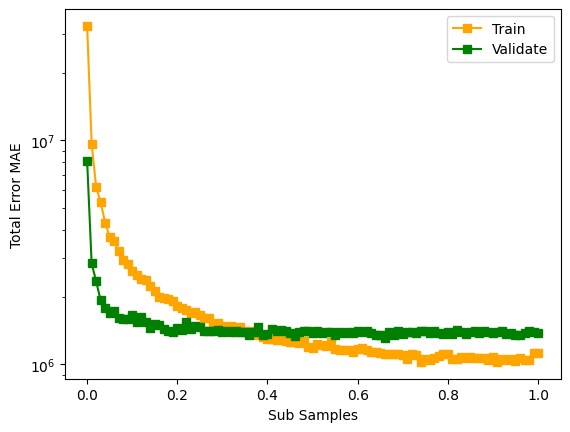

In [233]:
err = []
errIndex = []
errTest = []
scores = []
learnRate = np.linspace(0,1,101)[0:]
for depth in learnRate:
    xmodel = xgb.XGBRegressor(subsample = depth)
    xmodel.fit(Xtrain, ytrain)
    err.append(getTotalAbsoluteError(Xtrain, ytrain, xmodel))
    errTest.append(getTotalAbsoluteError(Xtest, ytest, xmodel))
    errIndex.append(depth)
    scores.append(xmodel.score(Xtest, ytest))

fig, ax = plt.subplots()
ax.plot(errIndex, err, 'rs-', color= 'orange', linewidth=1.5)
ax.plot(errIndex, errTest, 'rs-', color='green', linewidth= 1.5)
ax.set_xlabel('Sub Samples')
ax.set_ylabel('Total Error MAE')
ax.set_yscale('log')
plt.legend(['Train', 'Validate'])
print(scores)

#### Learn Rate

[-3.1022565196195853, 0.27594894820758975, 0.762776823170285, 0.838641565302626, 0.850526802032361, 0.8550725065519523, 0.851938878640087, 0.8536093183149406, 0.849637828118192, 0.8481538906038468, 0.8485778012027474, 0.8440968284891275, 0.8465726725980318, 0.8434912663003958, 0.8470151750089584, 0.8430612557066781, 0.8467403644255462, 0.849140225901668, 0.8374263861416426, 0.8459922116758088, 0.8451061920518845, 0.8403245039977596, 0.831403289978498, 0.8370042309483292, 0.8453799836129062, 0.8450198274625017, 0.8277563141438009, 0.8393182573643412, 0.8379045937308615, 0.8266114802869, 0.825092102575853, 0.8292237938957304, 0.825707753553459, 0.8360389269038321, 0.8357253682391805, 0.8246805150329072, 0.8138017458897543, 0.8341237594987185, 0.8385670695648646, 0.8182449771224287, 0.823934091062158, 0.8199989374076436, 0.8262579208407026, 0.8203869439283021, 0.8193908495039479, 0.8070292631861957, 0.8121681499512737, 0.8189661559620653, 0.8213576369972163, 0.8188778786627265, 0.82443027

C:\Users\msciz\AppData\Local\Temp\ipykernel_23012\461158419.py:15: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "rs-" (-> color='r'). The keyword argument will take precedence.
  ax.plot(errIndex, err, 'rs-', color= 'orange', linewidth=1.5)
C:\Users\msciz\AppData\Local\Temp\ipykernel_23012\461158419.py:16: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "rs-" (-> color='r'). The keyword argument will take precedence.
  ax.plot(errIndex, errTest, 'rs-', color='green', linewidth= 1.5)


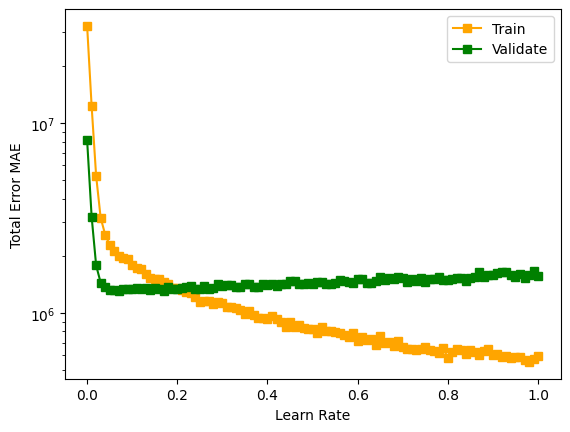

In [236]:
err = []
errIndex = []
errTest = []
scores = []
learnRate = np.linspace(0,1,101)
for depth in learnRate:
    xmodel = xgb.XGBRegressor(learning_rate = depth)
    xmodel.fit(Xtrain, ytrain)
    err.append(getTotalAbsoluteError(Xtrain, ytrain, xmodel))
    errTest.append(getTotalAbsoluteError(Xtest, ytest, xmodel))
    errIndex.append(depth)
    scores.append(xmodel.score(Xtest, ytest))

fig, ax = plt.subplots()
ax.plot(errIndex, err, 'rs-', color= 'orange', linewidth=1.5)
ax.plot(errIndex, errTest, 'rs-', color='green', linewidth= 1.5)
ax.set_xlabel('Learn Rate')
ax.set_ylabel('Total Error MAE')
ax.set_yscale('log')
plt.legend(['Train', 'Validate'])
print(scores)

#### Booster Type

C:\Users\msciz\AppData\Local\Temp\ipykernel_23012\3680150100.py:16: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "rs-" (-> color='r'). The keyword argument will take precedence.
  ax.plot(errIndex, err, 'rs-', color= 'orange', linewidth=1.5)
C:\Users\msciz\AppData\Local\Temp\ipykernel_23012\3680150100.py:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "rs-" (-> color='r'). The keyword argument will take precedence.
  ax.plot(errIndex, errTest, 'rs-', color='green', linewidth= 1.5)


[0.825092102575853, -21064350246266.3, 0.8250921026672121]


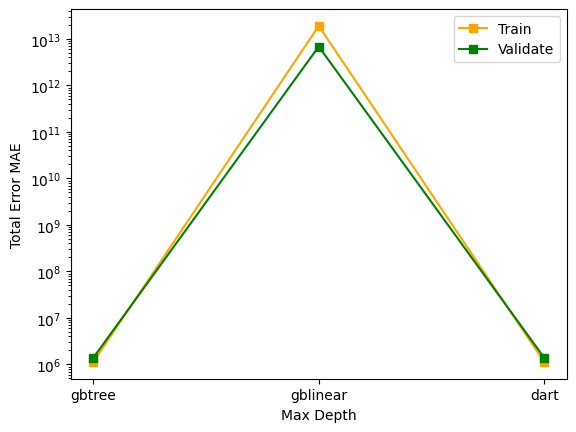

In [234]:
err = []
errIndex = []
errTest = []
scores = []
boosters = ['gbtree', 'gblinear', 'dart']
learnRate = np.linspace(0.04,0.06,21)
for depth in boosters:
    xmodel = xgb.XGBRegressor(booster = depth)
    xmodel.fit(Xtrain, ytrain)
    err.append(getTotalAbsoluteError(Xtrain, ytrain, xmodel))
    errTest.append(getTotalAbsoluteError(Xtest, ytest, xmodel))
    errIndex.append(depth)
    scores.append(xmodel.score(Xtest, ytest))

fig, ax = plt.subplots()
ax.plot(errIndex, err, 'rs-', color= 'orange', linewidth=1.5)
ax.plot(errIndex, errTest, 'rs-', color='green', linewidth= 1.5)
ax.set_xlabel('Boost Type')
ax.set_ylabel('Total Error MAE')
ax.set_yscale('log')
plt.legend(['Train', 'Validate'])
print(scores)

#### Delta Step

[-3.0596618531460544, -3.017361623266476, -2.975355601221517, -2.9336444948790907, -2.8922273968831904, -2.851104670742889, -2.8102765973637838, -2.7699949481836805, -2.730308743932241]


C:\Users\msciz\AppData\Local\Temp\ipykernel_23012\2805726930.py:16: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "rs-" (-> color='r'). The keyword argument will take precedence.
  ax.plot(errIndex, err, 'rs-', color= 'orange', linewidth=1.5)
C:\Users\msciz\AppData\Local\Temp\ipykernel_23012\2805726930.py:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "rs-" (-> color='r'). The keyword argument will take precedence.
  ax.plot(errIndex, errTest, 'rs-', color='green', linewidth= 1.5)


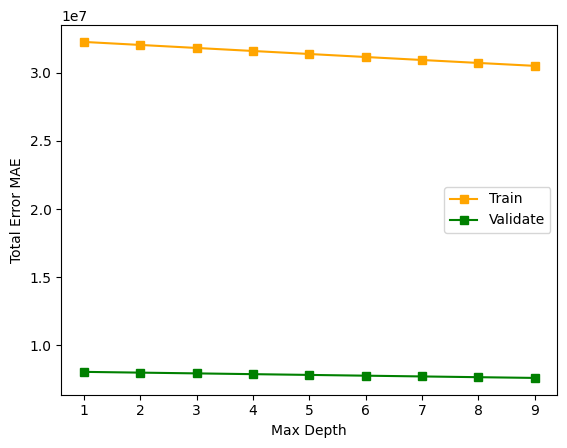

In [235]:
err = []
errIndex = []
errTest = []
scores = []
for depth in range(1,10):
    xmodel = xgb.XGBRegressor(max_delta_step = depth)
    xmodel.fit(Xtrain, ytrain)
    err.append(getTotalAbsoluteError(Xtrain, ytrain, xmodel))
    errTest.append(getTotalAbsoluteError(Xtest, ytest, xmodel))
    errIndex.append(depth)
    scores.append(xmodel.score(Xtest, ytest))

print(scores)

fig, ax = plt.subplots()
ax.plot(errIndex, err, 'rs-', color= 'orange', linewidth=1.5)
ax.plot(errIndex, errTest, 'rs-', color='green', linewidth= 1.5)
ax.set_xlabel('Delta Step')
ax.set_ylabel('Total Error MAE')
plt.legend(['Train', 'Validate'])

### Pickle it!

In [161]:
import pickle
filename = 'xgpickle.pkl'
pickle.dump(xmodel, open(filename, 'wb'))

In [121]:
print(xmodel.get_params)

<bound method XGBModel.get_params of XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)>


In [122]:
? xgb.XGBRegressor

Init signature:
 xgb.XGBRegressor(
    *,
    objective: Union[str, Callable[[numpy.ndarray, numpy.ndarray], Tuple[numpy.ndarray, numpy.ndarray]], NoneType] = 'reg:squarederror',
    **kwargs: Any,
) -> None
Docstring:     
Implementation of the scikit-learn API for XGBoost regression.


Parameters
----------

    n_estimators : int
        Number of gradient boosted trees.  Equivalent to number of boosting
        rounds.

    max_depth :  Optional[int]
        Maximum tree depth for base learners.
    max_leaves :
        Maximum number of leaves; 0 indicates no limit.
    max_bin :
        If using histogram-based algorithm, maximum number of bins per feature
    grow_policy :
        Tree growing policy. 0: favor splitting at nodes closest to the node, i.e. grow
        depth-wise. 1: favor splitting at nodes with highest loss change.
    learning_rate : Optional[float]
        Boosting learning rate (xgb's "eta")
    verbosity : Optional[int]
        The degree of verbosity. Valid

In [190]:
from random import randint

In [250]:
_ = randint(0, 365*24)
X.iloc[[_]], y.iloc[[_]]

(            hour  day_of_week  Temperature  Dew_Point   Humidity  Speed  Gust  \
 date                                                                            
 2022-03-04    16            4       35.425  15.791667  44.166667    0.0   0.0   
 
              Pressure  Precip_Rate  Precip_Accum   UV       Solar  public  
 date                                                                       
 2022-03-04  30.426667          0.0           0.0  0.0  187.666667     1.0  ,
 date
 2022-03-04    7599
 Name: Amount of Trips, dtype: int64)

0 [1109.4207]
1 [510.9671]
2 [269.98392]
3 [98.29848]
4 [6.673454]
5 [156.80142]
6 [1637.9683]
7 [4067.8665]
8 [4992.347]
9 [4626.0166]
10 [4613.61]
11 [4145.5264]
12 [4451.3438]
13 [4595.917]
14 [4829.559]
15 [5558.9375]
16 [5567.4614]
17 [5613.3716]
18 [5837.87]
19 [5918.848]
20 [5095.733]
21 [4311.304]
22 [4418.9985]
23 [3489.645]
0 [953.36957]
1 [227.41843]
2 [23.791174]
3 [-15.200996]
4 [41.650063]
5 [191.77803]
6 [1672.9451]
7 [4102.843]
8 [5027.3228]
9 [4720.7925]
10 [4708.3857]
11 [4378.0435]
12 [4683.8613]
13 [4683.8613]
14 [5931.7603]
15 [6383.993]
16 [6392.517]
17 [6438.4272]
18 [6940.0713]
19 [5893.4272]
20 [5070.312]
21 [5172.36]
22 [4774.6187]
23 [3713.2134]
0 [1191.2762]
1 [444.5781]
2 [258.71704]
3 [219.72495]
4 [276.57574]
5 [426.7038]
6 [1907.8713]
7 [4337.7695]
8 [5262.2485]
9 [4955.7183]
10 [4943.3115]
11 [4612.969]
12 [4918.787]
13 [4918.787]
14 [6166.686]
15 [6618.919]
16 [6627.443]
17 [6673.353]
18 [7445.211]
19 [6398.567]
20 [5578.989]
21 [5681.0366]
22 [5283.29

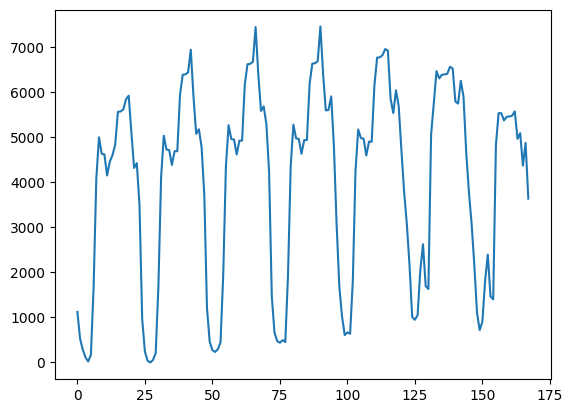

In [287]:
hours = [i for i in range(0,24)]
days = [a for a in range(0,7)]
dayresults = []
for day in days:
    for hour in hours:
        senstest = np.array([hour, day, 35, 15.5, 44, 0.0, 0.0, 30.326, 0.0, 0.0, 0.0, 187.7, 0])
        new = xmodel.predict(senstest.reshape(1,-1))
        # change = (new - y.iloc[[_]])
        # pchange = change / y.iloc[[_]]
        dayresults.append(new)

plt.plot(range(0,24*7), dayresults)
i = 0
for result in dayresults:
    print(i, result)
    i= (i+1)%24

In [276]:
new = xmodel.predict(senstest.reshape(1,-1))

change = (new - y.iloc[[_]])
pchange = change / y.iloc[[_]]
change, pchange

(date
 2022-03-04   -873.563477
 Name: Amount of Trips, dtype: float64,
 date
 2022-03-04   -0.114958
 Name: Amount of Trips, dtype: float64)

In [288]:
dfgwh.head()

,hour,Total Passengers,Amount of Trips,Total Distance,Average Distance,Total Fares,day_of_week,Temperature,Dew_Point,Humidity,Speed,Gust,Pressure,Precip_Rate,Precip_Accum,UV,Solar,public
date,,,,,,,,,,,,,,,,,,
2022-01-01,0,6716.0,4139,14253.79,3.345175,85222.39,5,50.266667,47.350000,89.916667,0.0,0.0,29.919167,0.0,0.0,0.0,0.0,2.0
2022-01-01,0,6716.0,4139,14253.79,3.345175,85222.39,5,50.266667,47.350000,89.916667,0.0,0.0,29.919167,0.0,0.0,0.0,0.0,1.0
2022-01-01,1,7391.0,4650,16036.43,3.209212,97587.01,5,50.266667,47.366667,90.000000,0.0,0.0,29.911667,0.0,0.0,0.0,0.0,2.0
2022-01-01,1,7391.0,4650,16036.43,3.209212,97587.01,5,50.266667,47.366667,90.000000,0.0,0.0,29.911667,0.0,0.0,0.0,0.0,1.0
2022-01-01,2,5703.0,3630,12345.28,3.164645,75531.61,5,50.400000,47.525000,90.000000,0.0,0.0,29.910000,0.0,0.0,0.0,0.0,2.0


<AxesSubplot:xlabel='date'>

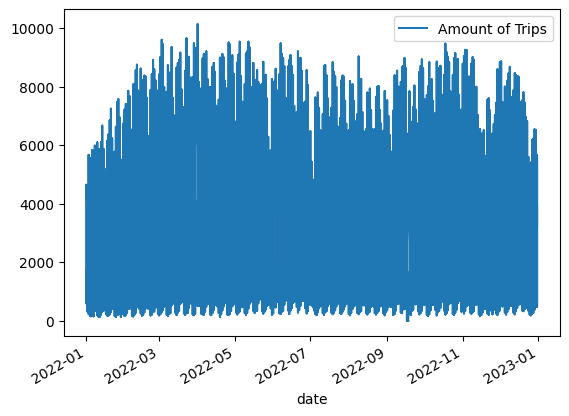

In [290]:
dfgwh.plot(use_index=True, y='Amount of Trips')

In [291]:
viz = dfgwh.reset_index()

In [312]:
viz.corr()

,hour,Total Passengers,Amount of Trips,Total Distance,Average Distance,Total Fares,day_of_week,Temperature,Dew_Point,Humidity,Speed,Gust,Pressure,Precip_Rate,Precip_Accum,UV,Solar,public
hour,1.000000,0.703104,0.685522,0.125944,-0.105454,0.683731,0.001126,0.093276,-0.000146,-0.169089,-0.013747,-0.007803,-0.021439,0.002111,0.038056,0.057345,0.063126,0.000624
Total Passengers,0.703104,1.000000,0.995024,0.201813,-0.160967,0.970079,0.018654,0.188434,0.038499,-0.257654,-0.020187,-0.010185,-0.021480,0.013373,0.030825,0.309406,0.353589,-0.046404
Amount of Trips,0.685522,0.995024,1.000000,0.207682,-0.158728,0.972855,-0.030120,0.182475,0.036673,-0.249141,-0.019650,-0.009642,-0.014510,0.011941,0.028424,0.317212,0.366848,-0.057368
Total Distance,0.125944,0.201813,0.207682,1.000000,0.559017,0.212038,-0.002160,0.070251,0.046919,-0.023655,-0.007091,-0.002563,-0.005485,-0.001806,-0.003466,0.066182,0.084979,-0.009029
Average Distance,-0.105454,-0.160967,-0.158728,0.559017,1.000000,-0.147690,-0.016623,0.007827,0.032993,0.056268,-0.001357,-0.002374,-0.010940,-0.005786,-0.008152,-0.053739,-0.061687,-0.003265
Total Fares,0.683731,0.970079,0.972855,0.212038,-0.147690,1.000000,-0.024911,0.205190,0.060673,-0.239833,-0.017881,-0.007935,-0.020068,0.012689,0.035557,0.306344,0.353410,-0.021134
day_of_week,0.001126,0.018654,-0.030120,-0.002160,-0.016623,-0.024911,1.000000,0.003964,0.018750,0.032929,-0.018505,-0.022377,-0.076346,0.048638,0.066970,-0.002404,-0.002476,0.035798
Temperature,0.093276,0.188434,0.182475,0.070251,0.007827,0.205190,0.003964,1.000000,0.889617,0.026686,0.004505,0.016075,-0.301799,0.000211,-0.012658,0.380680,0.291432,-0.092934
Dew_Point,-0.000146,0.038499,0.036673,0.046919,0.032993,0.060673,0.018750,0.889617,1.000000,0.470277,0.012334,0.027059,-0.363463,0.019611,-0.007107,0.191497,0.075321,-0.086337
Humidity,-0.169089,-0.257654,-0.249141,-0.023655,0.056268,-0.239833,0.032929,0.026686,0.470277,1.000000,0.020457,0.029823,-0.238646,0.046940,0.005867,-0.302605,-0.385467,0.006701


<AxesSubplot:>

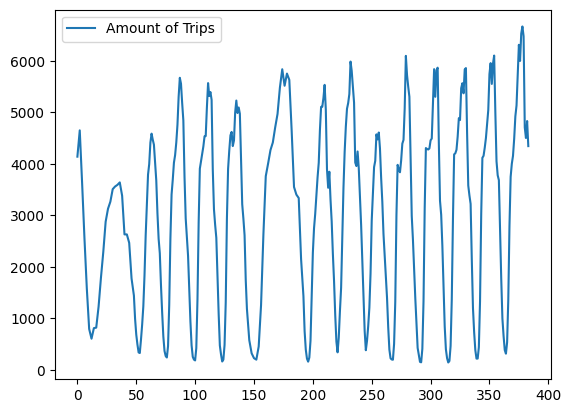

In [298]:
viz2 = viz[viz['date'] < '2022-01-15'].drop('public', axis = 1)
viz2.drop_duplicates().plot(use_index=True, y='Amount of Trips')

<AxesSubplot:>

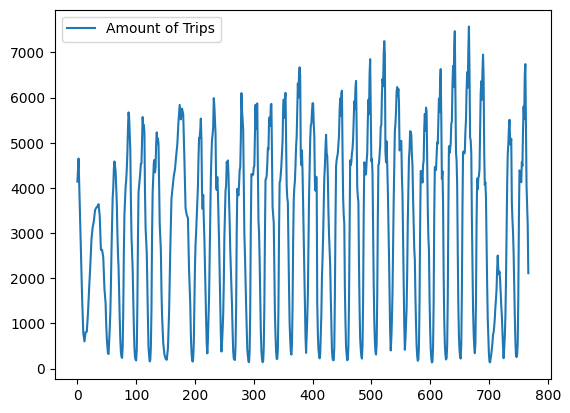

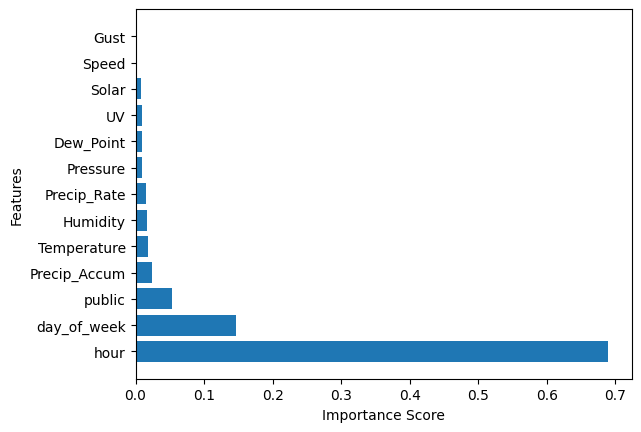

In [277]:
importance_scores = xmodel.feature_importances_

feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': importance_scores})

feature_importance = feature_importance.sort_values('Importance', ascending = False)

plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()

In [308]:
viz.value_counts('public')

public
0.0    5800
1.0    3236
2.0     288
dtype: int64

<AxesSubplot:xlabel='public'>

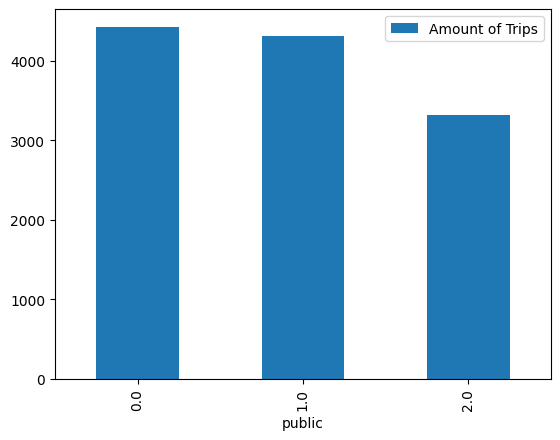

In [311]:
viz4 = viz.groupby('public').agg('sum')
viz4['Amount of Trips']= viz4['Amount of Trips']/viz.value_counts('public')
viz4.plot(kind='bar',use_index=True, y='Amount of Trips')

<AxesSubplot:xlabel='hour'>

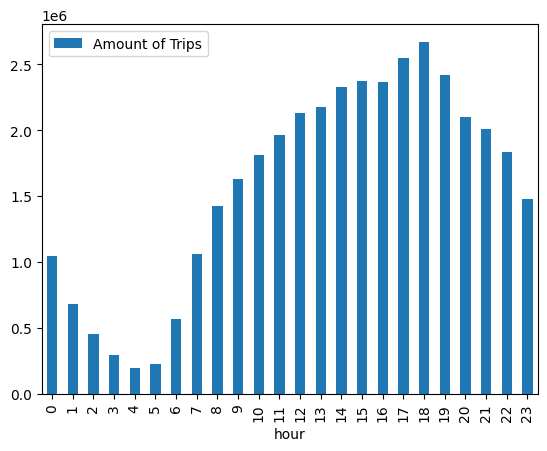

In [304]:
viz3 = viz.drop('public',axis=1).drop_duplicates().groupby('hour').agg('sum')
viz3.plot(kind='bar', use_index=True, y='Amount of Trips')

In [316]:
dfgwh.head()
dfgwh.drop('public',axis=1).reset_index().drop_duplicates().to_csv('MLdata.csv')

In [305]:
viz.head()

,date,hour,Total Passengers,Amount of Trips,Total Distance,Average Distance,Total Fares,day_of_week,Temperature,Dew_Point,Humidity,Speed,Gust,Pressure,Precip_Rate,Precip_Accum,UV,Solar,public
0,2022-01-01,0,6716.0,4139,14253.79,3.345175,85222.39,5,50.266667,47.350000,89.916667,0.0,0.0,29.919167,0.0,0.0,0.0,0.0,2.0
1,2022-01-01,0,6716.0,4139,14253.79,3.345175,85222.39,5,50.266667,47.350000,89.916667,0.0,0.0,29.919167,0.0,0.0,0.0,0.0,1.0
2,2022-01-01,1,7391.0,4650,16036.43,3.209212,97587.01,5,50.266667,47.366667,90.000000,0.0,0.0,29.911667,0.0,0.0,0.0,0.0,2.0
3,2022-01-01,1,7391.0,4650,16036.43,3.209212,97587.01,5,50.266667,47.366667,90.000000,0.0,0.0,29.911667,0.0,0.0,0.0,0.0,1.0
4,2022-01-01,2,5703.0,3630,12345.28,3.164645,75531.61,5,50.400000,47.525000,90.000000,0.0,0.0,29.910000,0.0,0.0,0.0,0.0,2.0


<AxesSubplot:xlabel='day_of_week'>

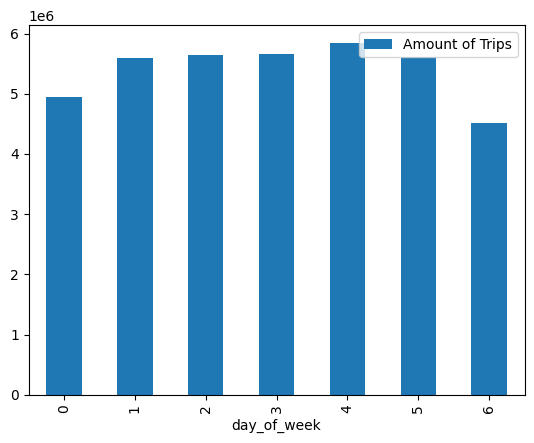

In [306]:
viz3 = viz.drop('public',axis=1).drop_duplicates().groupby('day_of_week').agg('sum')
viz3.plot(kind='bar', use_index=True, y='Amount of Trips')